# Imports and Constants

### Data Loading

In [1]:
!pip install datasets

import torch
from torch import nn
from datasets import load_dataset
from torch.utils.data import DataLoader

In [2]:
LANGUAGES = ["en", "de", "nl", "sv-SE", "da"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 1
TRAIN_BATCH = 1200
VAL_BATCH = 300
SAMPLE_RATE = 16000

# Constants related to the MFCC processing
# the number of samples per fft
N_FFT = 2048
# the amount of transform to shift
HOP_LENGTH = 512
# The number of coefficient we extract
N_MFCC = 13

### Data Processing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob # list out files in directory -> reading wave files

import librosa
import librosa.display
import IPython.display as ipd # play files

from itertools import cycle # colours and gimiks

### Training

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Download Dataset and Mount Drive

In [5]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# linking hugging face account
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineG

# Don't load the CNN

In [7]:
import random
def load_data(languages, train_batch, val_batch, randomOn=False):
  train_data = []
  val_data = []

  train_audio = []
  train_labels = []
  train_sr = []
  val_audio = []
  val_labels = []
  val_sr = []

  one_hot = F.one_hot(torch.tensor([0, 1, 2, 3, 4]), num_classes=len(languages))

  for i in range(len(one_hot)):
    one_hot[i] = one_hot[i].to(dtype=torch.float)

  for i in range(len(languages)):
    # Load common voice 17 dataset training set with streaming, and enabling custom code (necessary to load dataset correctly)
    if randomOn:
      train_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, trust_remote_code=True)
      train_data.append(train_set.shuffle(buffer_size=train_batch, seed=random.randrange(1,100)))
      val_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, trust_remote_code=True)
      val_data.append(val_set.shuffle(buffer_size=val_batch, seed=random.randrange(1,100)))
    else:
      train_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))
      val_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))

    it = iter(train_data[i])
    it2 = iter(val_data[i])

    for j in range(train_batch):
      train_item = next(it)

      if train_item:
        train_audio.append(train_item['audio']['array'])
        train_sr.append(train_item['audio']['sampling_rate'])
        train_labels.append(one_hot[i])

    for j in range(val_batch):
      val_item = next(it2)

      if val_item:
        val_audio.append(val_item['audio']['array'])
        val_sr.append(val_item['audio']['sampling_rate'])
        val_labels.append(one_hot[i])


    print(f"Loaded {languages[i]}")

  return train_audio, train_labels, train_sr, val_audio, val_labels, val_sr

In [52]:
train_audio, train_labels, train_sr, val_audio, val_labels, val_sr = load_data(LANGUAGES, TRAIN_BATCH, VAL_BATCH, randomOn=True)

Reading metadata...: 1101170it [00:27, 39650.83it/s]
Reading metadata...: 16393it [00:00, 34757.64it/s]


Loaded en


Reading metadata...: 589100it [00:13, 42500.86it/s]
Reading metadata...: 16183it [00:00, 44529.60it/s]


Loaded de


Reading metadata...: 34898it [00:00, 41800.92it/s]
Reading metadata...: 11252it [00:00, 34906.88it/s]


Loaded nl


Reading metadata...: 7744it [00:01, 4596.14it/s]
Reading metadata...: 5210it [00:00, 28458.03it/s]


Loaded sv-SE


Reading metadata...: 3484it [00:00, 12778.68it/s]
Reading metadata...: 2105it [00:00, 19050.37it/s]


Loaded da


# Data Processing

### Preprocessing

In [53]:
def process_batch(audio_data, sample_rates, batch_size, mfcc=True):
  audio_processed = []
  LENGTH =  5 * SAMPLE_RATE

  for i in range(batch_size):
    audio_resampled = librosa.resample(audio_data[i], orig_sr = sample_rates[i], target_sr = SAMPLE_RATE)

    audio_trimmed, _ = librosa.effects.trim(audio_resampled, top_db=60)

    if len(audio_trimmed) > LENGTH:
      audio_trimmed = audio_trimmed[:LENGTH]

    elif len(audio_trimmed) < LENGTH:
      padding =  LENGTH - len(audio_trimmed)
      audio_trimmed = np.pad(audio_trimmed, (0, padding), mode='constant')

    if mfcc:
      audio_trimmed = librosa.feature.mfcc(y = audio_trimmed, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)

    audio_processed.append(audio_trimmed)

    if i % TRAIN_BATCH == 0:
      print(f"Processed {i} audio files")

  return audio_processed

6000
Processed 0 audio files
Processed 1200 audio files
Processed 2400 audio files
Processed 3600 audio files
Processed 4800 audio files
(13, 469)


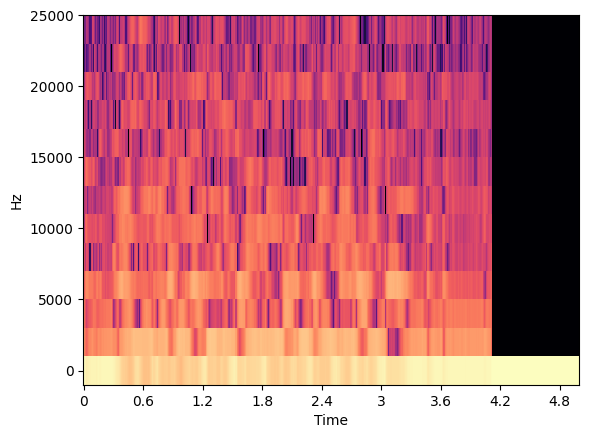

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

TEST_INDEX = 1

print(len(train_audio))
MFCC_train = process_batch(train_audio, train_sr, len(train_audio))

D = librosa.amplitude_to_db(np.abs(MFCC_train[TEST_INDEX]), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=SAMPLE_RATE)

print(MFCC_train[TEST_INDEX].shape)

In [55]:
MFCC_val = process_batch(val_audio, val_sr, len(val_audio))

Processed 0 audio files
Processed 1200 audio files


### Dataset Class Archive(Old, do not use)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np

class AudioDataset_old(Dataset):
    def __init__(self, audios, labels, sample_rates, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC, transform=None):
        """
        audios: list of raw audio arrays
        labels: list of labels
        """
        self.audios = audios
        self.labels = labels
        self.sample_rates = sample_rates
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.transform = transform

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        sr = self.sample_rates[idx]

        audio_length = SAMPLE_RATE*5

        # Resample
        audio_resampled = librosa.resample(audio, orig_sr = sr, target_sr = SAMPLE_RATE)

        # Trimming decibels
        audio_trimmed, _ = librosa.effects.trim(audio_resampled, top_db=80)

        # if audio too long trim down length (5 secs)
        if len(audio_trimmed) > audio_length:
          audio_trimmed = audio_trimmed[:audio_length]

        # if audio too short, add padding
        elif len(audio_trimmed) < audio_length:
          padding = audio_length - len(audio_trimmed)
          audio_trimmed = np.pad(audio_trimmed, (0, padding), mode='constant')

        # Calculate MFCCs for the trimmed audio
        mfcc = librosa.feature.mfcc(y = np.abs(audio_trimmed), sr=SAMPLE_RATE, n_fft=self.n_fft, hop_length=self.hop_length, n_mfcc=self.n_mfcc)
        mfcc = torch.tensor(mfcc, dtype=torch.float)

        return mfcc, label

In [ ]:
# audio_dataset = AudioDataset_old(train_audio, train_labels, train_sr)
# train_loader = DataLoader(audio_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### Dataset Class

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np

class AudioDataset(Dataset):
    def __init__(self, processed_audio, labels, sample_rates, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=N_MFCC, transform=None):
        """
        audios: list of raw audio arrays
        labels: list of labels
        """
        self.audios = processed_audio
        self.labels = labels
        self.sample_rates = sample_rates
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.transform = transform

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        audio = torch.tensor(audio, dtype=torch.float)

        return audio, label

In [56]:
audio_dataset = AudioDataset(MFCC_train, train_labels, train_sr)
train_loader = DataLoader(audio_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [57]:
audio_dataset = AudioDataset(MFCC_val, val_labels, val_sr)
val_loader = DataLoader(audio_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [58]:
i = 0
for data, label in train_loader:
  if i == 3:
    print(data.shape)
    print(label)
  i = i + 1

torch.Size([1, 13, 469])
tensor([[0, 0, 1, 0, 0]])


# CNN Model

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )

        self.gru_input_size = 128

        self.gru = nn.GRU(
            input_size=self.gru_input_size,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )

        self.attention = nn.Sequential(
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """
        Expected shape of x: [batch_size, time, n_mfcc]
        We first unsqueeze to add the channel dimension: -> [batch_size, 1, n_mfcc, time]
        Make sure n_mfcc is the 'frequency' dimension and time is the last dimension.
        """
        x = x.unsqueeze(1)

        x = self.conv_layers(x)

        x = x.squeeze(2)

        x = x.permute(0, 2, 1)

        gru_out, _ = self.gru(x)

        attention_scores = self.attention(gru_out)
        attention_weights = F.softmax(attention_scores, dim=1)  # across time
        context = torch.sum(attention_weights * gru_out, dim=1)

        logits = self.classifier(context)
        return logits, F.softmax(logits, dim=1)

### Training

In [44]:
def save_result(model_code, train_err, train_loss, val_err, val_loss):
  save_dir = "/content/drive/My Drive/training_results"
  os.makedirs(save_dir, exist_ok=True)
  model_path = os.path.join(save_dir, model_code)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


def save_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  os.makedirs(weight_dir, exist_ok=True)

  model_path = os.path.join(weight_dir, model_code)
  torch.save(net.state_dict(), f"{model_path}.pth")


def load_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  model_path = os.path.join(weight_dir, model_code)

  net.load_state_dict(torch.load(f"{model_path}.pth"))
  net.eval()
  return net

In [45]:
def plot_training_curve(model_code):
    import matplotlib.pyplot as plt

    save_dir = "/content/drive/My Drive/training_results"
    path = os.path.join(save_dir, model_code)

    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    # plt.title("Train vs Validation Error")
    plt.title("Train Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    # plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    # plt.title("Train vs Validation Loss")
    plt.title("Train Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    # plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [46]:
def train(model, model_name, data_loader, device, optimizer, loss_function, num_epochs, val_loader):
  start_time = time.time()
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  total_train_err = 0
  total_train_loss = 0

  for epoch in range(num_epochs):
    correct = 0
    total = 0
    epoch_loss = 0.0
    num_samples = 0
    for data, label in data_loader:
      data, label = data.to(DEVICE), label.to(DEVICE)
      logits, predictions = model(data)
      int_labels = label.argmax(dim=1)
      loss = loss_function(logits, int_labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      pred_classes = torch.argmax(logits, dim=1)
      true_classes = int_labels
      correct += (pred_classes == true_classes).sum().item()
      total += label.size(0)

      epoch_loss += loss.item() * data.size(0)
      num_samples += data.size(0)

    train_loss[epoch] = epoch_loss / num_samples
    train_err[epoch] = 100 - correct / total * 100
    model.eval()
    val_err[epoch], val_loss[epoch] = test_accuracy(model, val_loader, loss_function)
    model.train()

    save_weight(model, f"{model_name}_epoch_{epoch + 1}")
    print(f"Epoch #{epoch + 1} | Loss: {train_loss[epoch]} | Error: {train_err[epoch]}% | Loss: {val_loss[epoch]} | Error: {val_err[epoch]}%")

  save_result(model_name, train_err, train_loss, val_err, val_loss)

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"Time elapsed: {elapsed_time:.4f} seconds")

# Evaluation




In [47]:
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def test_accuracy(model, data_loader, loss_function):
    start_time = time.time()

    epoch_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data, label in data_loader:
          data, label = data.to(DEVICE), label.to(DEVICE)
          logits, predictions = model(data)
          int_labels = label.argmax(dim=1)
          loss = loss_function(logits, int_labels)

          epoch_loss += loss.item() * data.size(0)

          pred_classes = torch.argmax(logits, dim=1)
          true_classes = int_labels
          correct += (pred_classes == true_classes).sum().item()

          total += label.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total * 100

    end_time = time.time()
    elapsed_time = end_time - start_time
    return (100-accuracy), avg_loss

# *Training*

In [62]:
m_name = "cnn_test_4"

cnn = ConvNetwork(len(LANGUAGES)).to(DEVICE)

loss_function = nn.CrossEntropyLoss()
LEARNING_RATE=0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

train(cnn, m_name, train_loader, DEVICE, optimizer, loss_function, NUM_EPOCHS, val_loader)

plot_training_curve(m_name)

Epoch #1 | Loss: 1.5442555626276881 | Error: 70.4% | Loss: 1.5459291950265566 | Error: 71.06666666666666%
Epoch #2 | Loss: 1.4732746078242394 | Error: 66.69999999999999% | Loss: 1.7105126106838384 | Error: 72.19999999999999%
Epoch #3 | Loss: 1.421883938228258 | Error: 63.25% | Loss: 1.5759273800104856 | Error: 68.93333333333334%
Epoch #4 | Loss: 1.300589627708562 | Error: 57.56666666666666% | Loss: 2.7333061303404076 | Error: 70.06666666666666%
Epoch #5 | Loss: 1.2356955458795362 | Error: 53.96666666666667% | Loss: 2.1728073373097985 | Error: 74.4%
Epoch #6 | Loss: 1.1754173383821627 | Error: 49.4% | Loss: 2.2242428495627027 | Error: 75.73333333333333%
Epoch #7 | Loss: 1.0976774425925104 | Error: 44.983333333333334% | Loss: 2.488308773512045 | Error: 71.80000000000001%
Epoch #8 | Loss: 1.0371459153387521 | Error: 41.266666666666666% | Loss: 3.420290289294176 | Error: 75.73333333333333%


KeyboardInterrupt: 

# Not important Before this (wave2vec)


In [7]:
!pip install transformers datasets torchaudio

In [8]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

model_name = "facebook/wav2vec2-base"

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(LANGUAGES),
    output_hidden_states=True
)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at

In [18]:
import torchaudio

def preprocess_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)

    inputs = feature_extractor(
        waveform.squeeze().numpy(),
        sampling_rate=16000,
        max_length=16000 * 5,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    return inputs.input_values.squeeze(0)

In [19]:
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.wav2vec2 = model
        self.freeze_feature_extractor()

    def freeze_feature_extractor(self):
        # freezes pretrained layers so it doesn't overfit
        # b/c our dataset is so small.
        for param in self.wav2vec2.wav2vec2.parameters():
            param.requires_grad = False

    def forward(self, x):
        # raw waveform of shape(it's just [batch, 80000])
        outputs = self.wav2vec2(x)
        return outputs.logits

In [20]:
import random
def load_data(languages, train_batch, val_batch, randomOn=False):
  train_data = []
  val_data = []

  train_audio = []
  train_labels = []
  train_sr = []
  val_audio = []
  val_labels = []
  val_sr = []

  one_hot = F.one_hot(torch.tensor([0, 1, 2, 3, 4]), num_classes=len(languages))

  for i in range(len(one_hot)):
    one_hot[i] = one_hot[i].to(dtype=torch.float)

  for i in range(len(languages)):
    # Load common voice 17 dataset training set with streaming, and enabling custom code (necessary to load dataset correctly)
    if randomOn:
      train_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, trust_remote_code=True)
      train_data.append(train_set.shuffle(buffer_size=train_batch, seed=random.randrange(1,100)))
      val_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, trust_remote_code=True)
      val_data.append(val_set.shuffle(buffer_size=val_batch, seed=random.randrange(1,100)))
    else:
      train_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))
      val_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))

    it = iter(train_data[i])
    it2 = iter(val_data[i])

    for j in range(train_batch):
      train_item = next(it)

      if train_item:
        train_audio.append(train_item['audio']['array'])
        train_sr.append(train_item['audio']['sampling_rate'])
        train_labels.append(i)

    for j in range(val_batch):
      val_item = next(it2)

      if val_item:
        val_audio.append(val_item['audio']['array'])
        val_sr.append(val_item['audio']['sampling_rate'])
        val_labels.append(i)


    print(f"Loaded {languages[i]}")

  return train_audio, train_labels, train_sr, val_audio, val_labels, val_sr

In [21]:
def process_batch(audio_data, sample_rates, batch_size):
    audio_processed = []
    TARGET_SR = 16000  # Wav2Vec2 requires 16kHz so we are locked in this sr
    DURATION = 5
    MAX_LENGTH = TARGET_SR * DURATION

    for i in range(batch_size):
        audio_resampled = librosa.resample(
            audio_data[i],
            orig_sr=sample_rates[i],
            target_sr=TARGET_SR
        )

        audio_trimmed, _ = librosa.effects.trim(audio_resampled, top_db=30)

        if len(audio_trimmed) > MAX_LENGTH:
            audio_trimmed = audio_trimmed[:MAX_LENGTH]
        else:
            padding = MAX_LENGTH - len(audio_trimmed)
            audio_trimmed = np.pad(audio_trimmed, (0, padding), mode='constant')

        audio_processed.append(audio_trimmed.astype(np.float32))

    return audio_processed

In [22]:
from transformers import Wav2Vec2FeatureExtractor
from torch.utils.data import Dataset, DataLoader

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

class Wav2Vec2Dataset(Dataset):
    def __init__(self, audio_list, label_list):
        self.audio = audio_list  # List of raw waveforms (numpy arrays)
        self.labels = label_list # List of integer labels

    def __len__(self):
        return len(self.audio)

    def __getitem__(self, idx):
        return self.audio[idx], self.labels[idx]

def collate_fn(batch):
    audio_arrays = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)

    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        padding="max_length",
        max_length=80000,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True
    )

    return inputs.input_values, inputs.attention_mask, labels

In [24]:
from transformers import Wav2Vec2ForSequenceClassification

def train_wav2vec2():
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base-960h",
        num_labels=len(LANGUAGES)
    )

    for param in model.wav2vec2.parameters():
        param.requires_grad = False

    train_dataset = Wav2Vec2Dataset(train_processed, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)

    val_dataset = Wav2Vec2Dataset(val_processed, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(10):
        model.train()
        total_loss = 0

        correct = 0
        total_acc = 0

        for input_values, attention_mask, labels in train_loader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values, attention_mask=attention_mask, labels=labels)

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total_acc += labels.size(0)

            loss = outputs.loss


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        if epoch == 2:
            for param in model.wav2vec2.parameters():
                param.requires_grad = True

        val_acc, val_loss = evaluate_wav2vec2(model, val_loader, device, loss_fn)
        train_acc = correct / total_acc * 100
        print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

def evaluate_wav2vec2(model, loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for input_values, attention_mask, labels in loader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values, attention_mask=attention_mask)

            loss = criterion(outputs.logits, labels)
            total_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total * 100, total_loss / total

In [15]:
train_audio, train_labels, train_sr, val_audio, val_labels, val_sr = load_data(
    languages=LANGUAGES,
    train_batch=1200,
    val_batch=300,
    randomOn=True
)

Reading metadata...: 888827it [00:24, 31805.04it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c8b3d132-2fe1-454c-9f77-0cdf669bbd8c)')' thrown while requesting GET https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0/resolve/main/transcript/en/train.tsv
Retrying in 1s [Retry 1/5].
Reading metadata...: 1101170it [00:40, 26924.82it/s]
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: cc7fb0c7-6a3e-4b88-8018-a12f344d46b8)')' thrown while requesting GET https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0/resolve/main/audio/en/train/en_train_17.tar
Retrying in 1s [Retry 1/5].
Reading metadata...: 16393it [00:02, 5837.38it/s]


Loaded en


Reading metadata...: 589100it [00:17, 34122.58it/s]
Reading metadata...: 16183it [00:01, 9456.09it/s]


Loaded de


Reading metadata...: 34898it [00:01, 27860.91it/s]
Reading metadata...: 11252it [00:01, 7751.10it/s]


Loaded nl


Reading metadata...: 7744it [00:00, 18880.48it/s]
Reading metadata...: 5210it [00:01, 4646.72it/s]


Loaded sv-SE


Reading metadata...: 3484it [00:00, 11916.73it/s]
Reading metadata...: 2105it [00:00, 7679.32it/s]


Loaded da


In [16]:
train_processed = process_batch(train_audio, train_sr, len(train_audio))
val_processed = process_batch(val_audio, val_sr, len(val_audio))

In [25]:
train_wav2vec2()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 1.4799 | Train Acc: 39.13% | Val Loss: 1.4367 | Val Acc: 40.00%


KeyboardInterrupt: 